# Projeto Final
## Aluno: Daniel Anselmo Nascimento de Souza

O tema escolhido para o projeto final é a seção $5.4$ Some Stochastic Finance Models do livro *E. Allen, Modeling with Ito Stochastic Differential Equations-Springer (2007)*

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

from itertools import product
from collections import defaultdict

## Stock Price Model

### Modelo para 2 ações

O livro modela para duas ações $S_1$ e $S_2$ suas probabilidades relacionadas a subida de uma unidade, descida de uma unidade e manter seu preço.

Dessa forma é construída a partir de vetores onde as entradas são +1, 0 ou -1 e a primeira entrada é relacionada a ação $S_1$ e a segunda entrada é relacionada a ação $S_2$

Exemplos: O vetor $ [1, 0]$ em um intervalo de tempo $ \delta t$ representa o ganho em 1 unidade para a ação $ S_1 $ e a manutenção de seu preço para a ação $ S_2$

<br>

Dessa forma para duas ações temos: $ 3 \cdot 3 = 9 $ possibilidades

A partir daí temos a seguinte tabela:

$$ \begin{array}{c} \hline
\text{Change } [\Delta S_1, \Delta S_2]^T & \text{Probability} \\ \hline
[\Delta S_1, \Delta S_2]_1^T = [1, 0]^T & p_1 = b_1 S_1 \Delta t \\
[\Delta S_1, \Delta S_2]_2^T = [-1, 0]^T & p_2 = d_1 S_1 \Delta t \\
[\Delta S_1, \Delta S_2]_3^T = [0, 1]^T & p_3 = b_2 S_2 \Delta t \\
[\Delta S_1, \Delta S_2]_4^T = [0, -1]^T & p_4 = d_2 S_2 \Delta t \\
[\Delta S_1, \Delta S_2]_5^T = [1, 1]^T & p_5 = m_{22} S_1 S_2 \Delta t \\
[\Delta S_1, \Delta S_2]_6^T = [1, -1]^T & p_6 = m_{21} S_1 S_2 \Delta t \\
[\Delta S_1, \Delta S_2]_7^T = [-1, 1]^T & p_7 = m_{12} S_1 S_2 \Delta t \\
[\Delta S_1, \Delta S_2]_8^T = [-1, -1]^T & p_8 = m_{11} S_1 S_2 \Delta t \\
[\Delta S_1, \Delta S_2]_9^T = [0, 0]^T & p_9 = 1 - \sum_{i=1}^{8} p_i \\ \hline
\end{array} $$

Acima temos todos os 9 possíveis caminhos para a mudança em um intervalo $ \Delta t $ das ações $ S_1 $ e $ S_2$

### Implementação das probs e parâmetros

In [ ]:
caminhos_2S = [[ 1,  0],
[-1,  0],
[ 0,  1],
[ 0, -1],
[ 1,  1],
[ 1, -1],
[-1,  1],
[-1, -1],
[ 0,  0]]

In [ ]:
def change_stock(Stock, t, change):
  '''
  Return boolean
  '''
  if change == -1:
    return Stock[t] - Stock[t-1] < 0

  elif change == 0:
    return Stock[t] - Stock[t-1] == 0

  elif change == 1:
    return Stock[t] - Stock[t-1] > 0

In [ ]:
def prob_stocks(list_stocks, paths):
  probs = np.zeros(3**(len(list_stocks)))
  n = len(list_stocks[0])

  for t in range(1,n): # para cada dia

    for i, path in enumerate(paths): # para cada caminho
      bools_list = []

      for j, change in enumerate(path): # Para cada uma das possíveis mudanças para cada ação em path
        bools_list.append(change_stock(list_stocks[j], t, change))

      if all(bools_list):
        probs[i] += 1 # Contagem de ocorrência do evento

  return probs/(n-1) # Normalização para virar probabilidade

In [ ]:
import yfinance as yf
import pandas_datareader.data as web
yf.pdr_override()

# Calcula os retornos diários

price_weg = web.get_data_yahoo(['WEGE3.SA'], start = '2024-01-01',
                            end = '2024-07-01')['Close']

price_itau = web.get_data_yahoo(['ITUB4.SA'], start = '2024-01-01',
                            end = '2024-07-01')['Close']

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


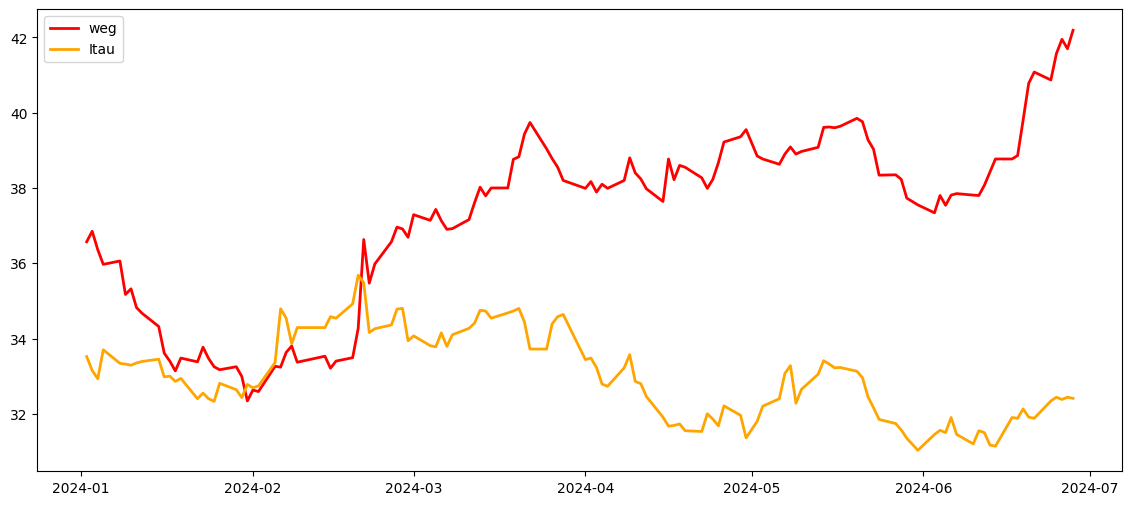

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(price_weg, label='weg', color='red', linewidth=2)
plt.plot(price_itau, label='Itau', color='orange', linewidth=2)
plt.legend()
plt.show()

In [ ]:
probs_2stocks = prob_stocks([price_itau, price_weg], caminhos_2S)

print(np.sum(probs_2stocks))
print(abs(np.sum(probs_2stocks) - 1))

0.9999999999999999
1.1102230246251565e-16


### Implementação da SDE

Com as probabilidades em mãos, conseguimos calcular os parametros de entrada do modelo


### Calibragem das Probs

In [ ]:
dias_totais = len(price_weg)
test = 5/6

dias_calibragem = int(dias_totais * test)
dias_simulados = dias_totais - dias_calibragem

probs_weg_itau = prob_stocks([price_weg[0:dias_calibragem],price_itau[0:dias_calibragem]], caminhos_2S)

probs_weg_itau

array([0.00980392, 0.00980392, 0.00980392, 0.        , 0.25490196,
       0.21568627, 0.20588235, 0.29411765, 0.        ])

$$\begin{equation}
E(\Delta S) = \sum_{j=1}^{9} p_j \Delta S_j = \left[
\begin{array}{c}
(b_1 - d_1)S_1 + (m_{22} + m_{21} - m_{12} - m_{11})S_1 S_2 \\
(b_2 - d_2)S_2 + (m_{22} - m_{21} + m_{12} - m_{11})S_1 S_2
\end{array}
\right] \Delta t = \mu(t, S_1, S_2) \Delta t
\end{equation}$$

$$\begin{equation}
E(\Delta S (\Delta S)^T) = \sum_{j=1}^{9} p_j \Delta S_j (\Delta S_j)^T = \left[
\begin{array}{cc}
c_1 + c_2 + c_3 & c_2 - c_3 \\
c_2 - c_3 & c_2 + c_3 + c_4
\end{array}
\right] \Delta t = V(t, S_1, S_2) \Delta t
\end{equation} $$

Sabendo que $ B = (V)^{1/2}$, temos:

$$
B(t, S_1, S_2) = \frac{1}{d}
\left[
\begin{array}{cc}
c_1 + c_2 + c_3 + k & c_2 - c_3 \\
c_2 - c_3 & c_2 + c_3 + c_4 + k \\
\end{array}
\right]
$$

onde k e d são dados por:
$$
k = \sqrt{(c_1 + c_2 + c_3)(c_2 + c_3 + c_4) - (c_2 - c_3)^2}
$$

$$
d = \sqrt{c_1 + 2c_2 + 2c_3 + c_4 + 2k}
$$


Dessa forma nossa SDE para o modelo de duas ações fica:

$$dS(t) = \mu(t, S_1, S_2) \, dt + B(t, S_1, S_2) \, dW(t)$$

### Modelo

In [ ]:
def num_sde_2stocks(Stock1_0, Stock2_0, probs, tf, dt):

  ### PARAMETROS
  b1 = probs[0]/(Stock1_0*dt)
  d1 = probs[1]/(Stock1_0*dt)
  b2 = probs[2]/(Stock2_0*dt)
  d2 = probs[3]/(Stock2_0*dt)
  m22 = probs[4]/(Stock1_0*Stock2_0*dt)
  m21 = probs[5]/(Stock1_0*Stock2_0*dt)
  m12 = probs[6]/(Stock1_0*Stock2_0*dt)
  m11 = probs[7]/(Stock1_0*Stock2_0*dt)

  ts = np.arange(0, tf, dt)
  num = len(ts)

  S1 = [Stock1_0]
  S2 = [Stock2_0]

  #Gerando o mov browniano 2D
  W1 = np.zeros(num)
  dW1 = np.sqrt(dt)*np.random.normal(size=num-1)
  W1[1:] = np.cumsum(dW1)

  W2 = np.zeros(num)
  dW2 = np.sqrt(dt)*np.random.normal(size=num-1)
  W2[1:] = np.cumsum(dW2)

  W2D = np.array([W1, W2])    #Mov browniano 2D
  DW2D = np.array([dW1, dW2]).T #Incrementos do Mov Browniano 2D

  for t in range(num-1):

    # calculando mu(t, S1, S2)
    mu = np.array([(b1 - d1)*S1[-1] + (m22 + m21 - m12 - m11)*S1[-1]*S2[-1], (b2 - d2)*S2[-1] + (m22 - m21 + m12 - m11)*S1[-1]*S2[-1]])

    # calculando B(t, S1, S2)
    c1 = (b1 + d1)*S1[-1]
    c2 = (m22 + m11)*S1[-1]*S2[-1]
    c3 = (m21 + m12)*S1[-1]*S2[-1]
    c4 = (b2 + d2)*S2[-1]
    k = np.sqrt((c1 + c2 + c3)*(c2 + c3 + c4) - (c2 - c3)**2)
    d = np.sqrt(c1 + 2*c2 + 2*c3 + c4 + 2*k)

    B = np.array([[c1 + c2 + c3 + k, c2 - c3], [c2 - c3, c2 + c3 + c4 + k]])/d

    # calculando dS(t)
    dS = mu*dt + B@DW2D[t]

    S1.append(S1[-1] + dS[0])
    S2.append(S2[-1] + dS[1])

  return ts, S1, S2

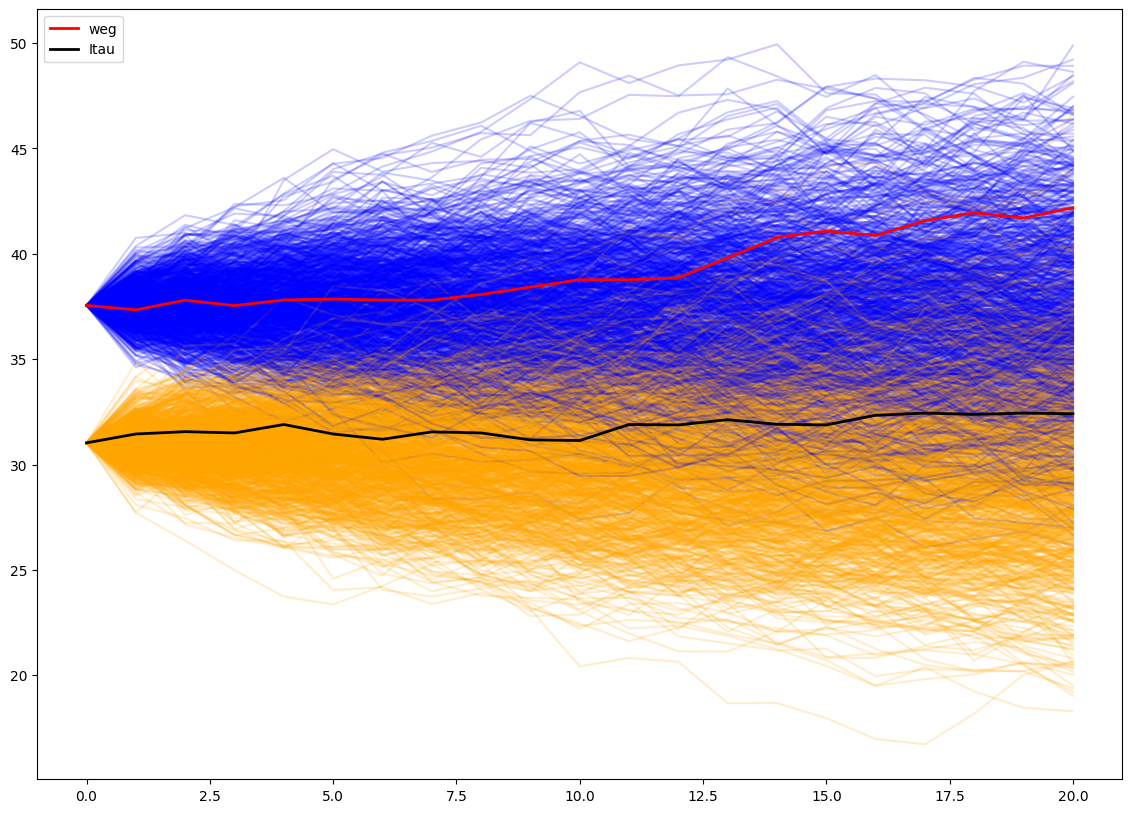

In [ ]:
plt.figure(figsize=(14,10))

for _ in range(1000):
  ts, S1, S2 = num_sde_2stocks(price_weg[dias_calibragem], price_itau[dias_calibragem], probs_weg_itau, dias_simulados, 1)
  plt.plot(ts, S1, color='blue', alpha = 0.2)
  plt.plot(ts, S2, color='orange', alpha = 0.2 )

plt.plot(ts, np.array(price_weg[dias_calibragem:]), label='weg', color='red', linewidth=2)
plt.plot(ts, np.array(price_itau[dias_calibragem:]), label='Itau', color='black', linewidth=2)
plt.legend()
plt.show()

## Interest Rate

### Vasicek Model

$$ dr_t = \kappa(\theta -r_t)dt + \sigma dW_t $$

A solução dessa SDE é:

$$ r_t = \theta + (r_0 - \theta)e^{-\kappa t} + e^{-\kappa t} \sigma \int_{0}^{t} e^{\kappa s}dW_s $$

<br>

Dessa forma, temos:

$$ 𝔼[r_t] = \theta + (r_0 - \theta)e^{-\kappa t} $$


Note que se $ t \longrightarrow \infty$, temos que $ 𝔼[r_t] = \theta $


$$ Var[r_t] = Var \left[ e^{-\kappa t} \sigma \int_{0}^{t} e^{\kappa s}dW_s \right] $$
$$          = \sigma^{2} \int_{0}^{t}  e^{-2\kappa s}  ds $$
$$          = \frac{\sigma^{2}}{2\kappa } (1- e^{-2\kappa t})  $$

Note que se $ t \longrightarrow \infty$, temos que $ Var[r_t] = \frac{\sigma^{2}}{2\kappa}$

#### Discretização do Modelo Vasicek

$$ r_{t+dt} - r_{t} = \kappa (\theta - r_t) dt + \sigma \sqrt{r_t} \cdot \mathcal{N}(0,dt) $$

<br>

$$ y_i = \beta_{1}z_{1,i} + \beta_{2}z_{2,i} + \epsilon_i $$

Onde:

$$ y_i = r_{t+dt} - r_{t} $$

$$ \beta_{1} = \kappa \theta $$

$$ \beta_{2} = -\kappa $$

$$ z_{1,i} = dt $$

$$ z_{2,i} = r_t dt $$

$$ \epsilon_i = \sigma \sqrt{dt} \mathcal{N}(0,1) $$

#### Estimando parametros via Regressão Linear

In [ ]:
def ols_vasicek(data, dt):
  # definindo variáveis
  Nsteps = len(data)
  rs = data[:Nsteps - 1]
  rt = data[1:Nsteps]

  # Inicialização do Modelo
  model = LinearRegression()

  y = (rt - rs)
  z1 = np.ones(len(rs))*dt
  z2 = rs * dt

  X = np.column_stack((z1, z2))

  # fit
  model = LinearRegression(fit_intercept=False)
  model.fit(X, y)

  # predict, residual and parameters
  y_hat = model.predict(X)
  residuals = y - y_hat
  beta1 = model.coef_[0]
  beta2 = model.coef_[1]

  # parameters
  k0 = -beta2
  theta0 = beta1/k0
  sigma0 = np.sqrt( (np.sum(residuals**2)/ (Nsteps - (2)) ) / dt )

  return k0, theta0, sigma0

### CIR Model

$$  dr_t = \kappa (\theta - r_t) dt + \sigma \sqrt{r_t} dW_t$$


A solução do modelo CIR é dada por:

$$r_t = \theta + (r_0 - \theta)e^{-\kappa t} + \sigma e^{-\kappa t} \int_0^t e^{\kappa s} \sqrt{r_s} \, dW_s.$$



$$ 𝔼[r_t] = \theta + (r_0 - \theta)e^{-\kappa t}  $$


$$ \mathrm{Var}[r_t] = \frac{\sigma^2 r_e}{2 \alpha} + \frac{\sigma^2 (r_0 - r_e)}{\alpha} e^{-\alpha t} + \left( \frac{\sigma^2 r_e}{2 \alpha} - \frac{\sigma^2 r_0}{\alpha} \right) e^{-2 \alpha t}  $$

#### Discretização do Modelo CIR



$$ r_{t+dt} - r_{t} = \kappa (\theta - r_t) dt + \sigma \sqrt{r_t} \cdot \mathcal{N}(0,dt) $$

<br>

$$ \frac{r_{t+dt} - r_{t}}{\sqrt{r_t}} = \frac{\kappa \theta dt}{\sqrt{r_t}} - \kappa \sqrt{r_t}dt + \sigma \sqrt{dt} \mathcal{N}(0,1) $$

<br>

$$ y_i = \beta_{1}z_{1,i} + \beta_{2}z_{2,i} + \epsilon_i $$

Onde:

$$ y_i = \frac{r_{t+dt} - r_{t}}{\sqrt{r_t}}  $$

$$ \beta_{1} = \kappa \theta $$

$$ \beta_{2} = -\kappa $$

$$ z_{1,i} = \frac{dt}{\sqrt{r_t}} $$

$$ z_{2,i} = \sqrt{r_t} dt $$

$$ \epsilon_i = \sigma \sqrt{dt} \mathcal{N}(0,1) $$

In [ ]:
def ols_cir(data, dt):
  # definindo variáveis
  Nsteps = len(data)
  rs = data[:Nsteps - 1]
  rt = data[1:Nsteps]

  # Inicialização do modelo
  model = LinearRegression()

  y = (rt - rs) / np.sqrt(rs)
  z1 = dt / np.sqrt(rs)
  z2 = dt * np.sqrt(rs)
  X = np.column_stack((z1, z2))

  # fit
  model = LinearRegression(fit_intercept=False)
  model.fit(X, y)

  # predict, residualss and parameters
  y_hat = model.predict(X)
  residuals = y - y_hat
  beta1 = model.coef_[0]
  beta2 = model.coef_[1]

  # parameters
  k0 = -beta2
  theta0 = beta1/k0
  sigma0 = np.sqrt( (np.sum(residuals**2)/ (Nsteps - (2)) ) / dt )

  return k0, theta0, sigma0

### Implementação na Prática

In [ ]:
!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git
from tvDatafeed import TvDatafeed, Interval

  Cloning https://github.com/rongardF/tvdatafeed.git to /tmp/pip-req-build-neyutrtg
  Running command git clone --filter=blob:none --quiet https://github.com/rongardF/tvdatafeed.git /tmp/pip-req-build-neyutrtg
  Resolved https://github.com/rongardF/tvdatafeed.git to commit e6f6aaa7de439ac6e454d9b26d2760ded8dc4923
  Preparing metadata (setup.py) ... done


In [ ]:
tv = TvDatafeed()

# Preços de mercado 1
DI_index_data1 = tv.get_hist(symbol ='DI11!',exchange = 'BMFBOVESPA', interval=Interval.in_daily, n_bars = 64) # Séries de preços da DI11

datas1 = [dt.strftime('%Y-%m-%d') for dt in DI_index_data1.index] # Dias no formato YYYY-MM-DD da série de preços da DI11
DI_index_data1.index = datas1 # Indexando com os dias no formato YYYY-MM-DD

price_di11 = pd.DataFrame(DI_index_data1['close']) / 100 # Preços de fechamento da DI11
prices_di11 = np.array(price_di11['close'])

In [ ]:
!pip install python-bcb

from bcb import sgs

In [ ]:
selic = sgs.get(('selic', 432), start = '2024-01-01')[-64:]
juros = np.array(selic['selic'])/100

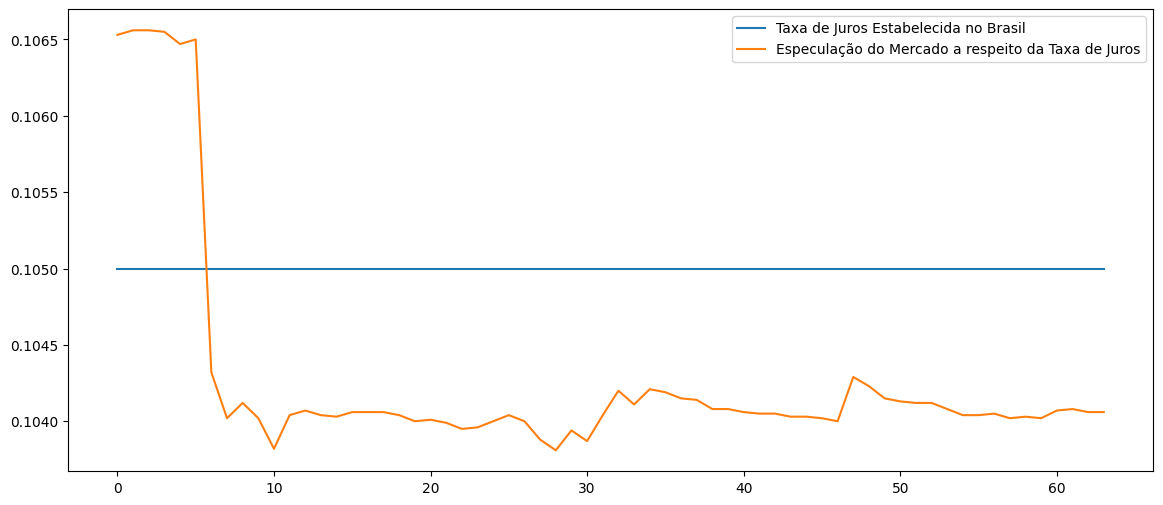

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(juros, label = 'Taxa de Juros Estabelecida no Brasil')
plt.plot(np.array(prices_di11), label = 'Especulação do Mercado a respeito da Taxa de Juros')
plt.legend()
plt.show()

#### Simulação do Modelo Vasicek

#### Calibração

In [ ]:
# model calibration
test = 2/3
estimates = ols_vasicek(prices_di11[0:int(test*len(prices_di11))], 1/len(prices_di11[0:int(test*len(prices_di11))])) # época de calibração
print(f"The estimates are: k = {round(estimates[0], 3)}, theta = {round(estimates[1], 3)}, sigma = {round(estimates[2], 3)}")

k_vasicek, theta_vasicek, sigma_vasicek = estimates

The estimates are: k = 6.205, theta = 0.104, sigma = 0.002


#### Método Numérico

In [ ]:
def simulate_vasicek(k, theta, sigma, r0, T, N):

  # populate an empty array
  dt = T / N
  interest_rate_paths = np.zeros(N+1)
  interest_rate_paths[0] = r0

  for t in range(1, N+1):
      r = interest_rate_paths[t-1]

      Z = np.random.randn() # Normal(0,1)
      r_next = r + k*(theta-r)*dt + sigma*np.sqrt(dt)*Z

      interest_rate_paths[t] = r_next

  return interest_rate_paths

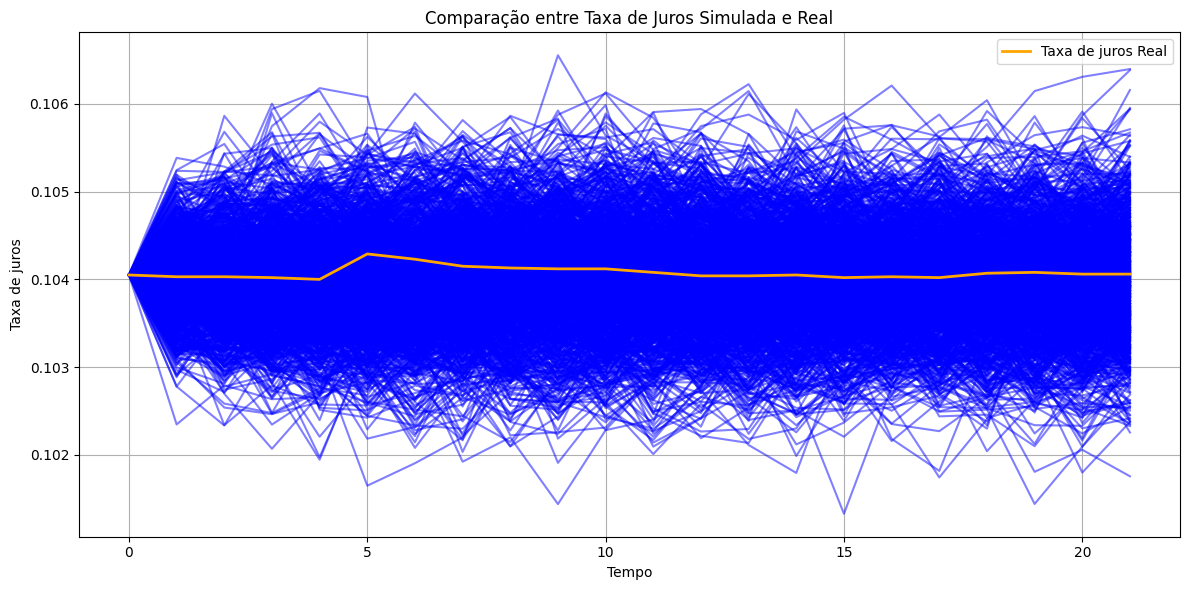

In [ ]:
plt.figure(figsize=(12, 6))

# Plotando rate_predict
for _ in range(1000):
    rate_predict = simulate_vasicek(k_vasicek, theta_vasicek, sigma_vasicek,
                                    prices_di11[int(test*len(prices_di11))], 1, len(prices_di11) - int(test*len(prices_di11)) - 1)  # Simulação
    plt.plot(rate_predict, color='blue', alpha=0.5)

# Plotando rate_real uma vez para comparação
plt.plot(prices_di11[int(test*len(prices_di11)):], label='Taxa de juros Real', color='orange', linewidth=2)

plt.xlabel('Tempo')
plt.ylabel('Taxa de juros')
plt.title('Comparação entre Taxa de Juros Simulada e Real')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Simulação Modelo CIR

#### Calibração

In [ ]:
# model calibration
test = 2/3
estimates = ols_cir(prices_di11[0:int(test*len(prices_di11))], 1/len(prices_di11[0:int(test*len(prices_di11))])) # época de calibração
print(f"The estimates are: k = {round(estimates[0], 3)}, theta = {round(estimates[1], 3)}, sigma = {round(estimates[2], 3)}")

k_cir, theta_cir, sigma_cir = estimates

The estimates are: k = 6.211, theta = 0.104, sigma = 0.006


#### Método Numérico

In [ ]:
def simulate_cir(k, theta, sigma, r0, T, N):

  # populate an empty array
  dt = T / N
  interest_rate_paths = np.zeros(N+1)
  interest_rate_paths[0] = r0

  for t in range(1, N+1):
      r = interest_rate_paths[t-1]
      r_next = -1

      while r_next < 0:
        Z = np.random.randn() # Normal(0,1)
        r_next = r + k*(theta-r)*dt + sigma*np.sqrt(dt)*np.sqrt(r)*Z

      interest_rate_paths[t] = r_next

  return interest_rate_paths

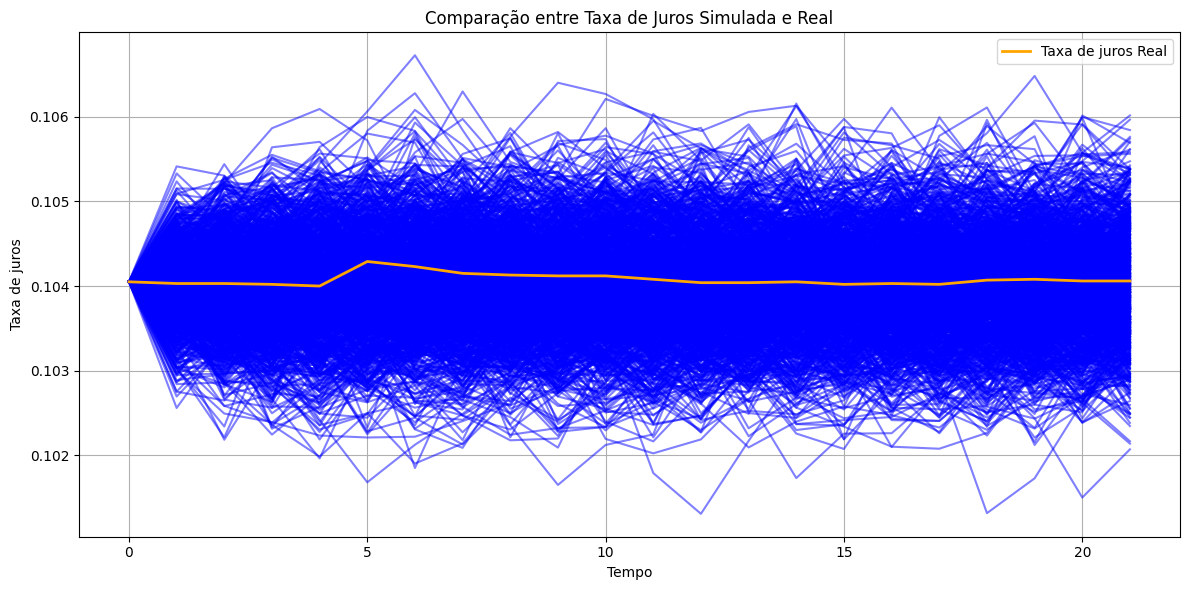

In [ ]:
plt.figure(figsize=(12, 6))

# Plotando rate_predict
for _ in range(1000):
    rate_predict = simulate_cir(k_cir, theta_cir, sigma_cir,
                                prices_di11[int(test*len(prices_di11))], 1, len(prices_di11) - int(test*len(prices_di11)) - 1)  # Simulação
    plt.plot(rate_predict, color='blue', alpha=0.5)

# Plotando rate_real uma vez para comparação
plt.plot(prices_di11[int(test*len(prices_di11)):], label='Taxa de juros Real', color='orange', linewidth=2)

plt.xlabel('Tempo')
plt.ylabel('Taxa de juros')
plt.title('Comparação entre Taxa de Juros Simulada e Real')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()